## Joseph Rochelle
## DSC 550 Data Mining
## Orgional Final Case Study

**Link to data:** https://www.kaggle.com/lava18/google-play-store-apps?select=googleplaystore.csv

**Problem Statement:**

We live in a world where there are apps for everything. As a great idea emerges, a developer simply uploads the apps to Apple and Google stores for users to receive for free or to pay for service. Investors need predictive frameworks to predict high ratings and downloads, which can assist with determining if the app should be free, free with advertisements, or a paid service. By creating a predictive model, investors can access the mode of which the app should be uploaded to yield the strongest return on investment as the app is intended to scale. 


**Proposal of solutions:** 

By using the `google play store` data set, I will create three regression models: (a) un-regularized linear regression, (b) regularized linear regression, and (c) random forest regression. I will utilizes these three models in a cross-validated pipeline, by judging their performance on a data set by mean squared errors. After determining the best model, I will evaluate my final model (trained on the previous three training sets) to demonstrate an objective mdoel that should generalize well in the future. 

Using the paramaters found, I will train a final model using all the data and explore the most approriate strategy: If one of the regression models, the magniture of the coefficents will be examined; if it is the Random Forest regression model, the feature importance will be used. 

In [127]:
import re
import sys

import time
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [56]:
df= pd.read_csv("googleplaystore.csv")
df.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## Pandas Profilling for Exploratory Data Analysis

After the data frame is loaded, it is important to look through the data for what needs to be cleaned and transformed. One of the most powerful tools in the industry today is Pandas Profilling. Within the pandas profilling report, the researcher can get an overview of what is in the data, the variables that are within the data frame and see how they interat, you can see the correlations of the data, missing values, sample of the data, and even duplicate rows. 

In addition to reviewing the data, the researcher can see the histograms of the data and the outputs. 

In [3]:
from pandas_profiling import ProfileReport
prof = ProfileReport(df)
prof

In [57]:
%matplotlib inline

In [58]:
sns.set(style='darkgrid')
sns.set_palette('PuBuGn_d')

App               False
Category          False
Rating             True
Reviews           False
Size              False
Installs          False
Type               True
Price             False
Content Rating     True
Genres            False
Last Updated      False
Current Ver        True
Android Ver        True
dtype: bool

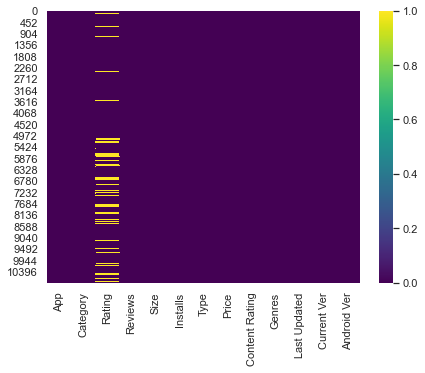

In [59]:
plt.figure(figsize=(7, 5))
sns.heatmap(df.isnull(), cmap='viridis')
df.isnull().any()

**Discussion:**

 Based off the findings from pandas profilling, the data frame was cleaned and transformed to be usable among the regression models that will be used. Values were cleaned from missing sections, duplicates moved, and outliers like one random category removed. 

In [60]:
# The best way to fill missing values might be using the median instead of mean.
df['Rating'] = df['Rating'].fillna(df['Rating'].median())

# Before filling null values we have to clean all non numerical values & unicode charachters 
#Found these functions through various sections of data cleaning
replaces = [u'\u00AE', u'\u2013', u'\u00C3', u'\u00E3', u'\u00B3', '[', ']', "'"]
for i in replaces:
	df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace(i, ''))

regex = [r'[-+|/:/;(_)@]', r'\s+', r'[A-Za-z]+']
for j in regex:
	df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : re.sub(j, '0', x))

df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace('.', ',',1).replace('.', '').replace(',', '.',1)).astype(float)
df['Current Ver'] = df['Current Ver'].fillna(df['Current Ver'].median())

In [61]:
# Count the number of unique values in category column 
df['Category'].unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION',
       '1.9'], dtype=object)

In [62]:
# Check the record  of unreasonable value which is 1.9
i = df[df['Category'] == '1.9'].index
df.loc[i]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0,NaN


In [63]:
# Drop this bad column
df = df.drop(i)

In [64]:
# Removing NaN values
df = df[pd.notnull(df['Last Updated'])]
df = df[pd.notnull(df['Content Rating'])]

In [65]:
# App values encoding
le = preprocessing.LabelEncoder()
df['App'] = le.fit_transform(df['App'])
# This encoder converts the values into numeric values

In [66]:
# Category features encoding
category_list = df['Category'].unique().tolist() 
category_list = ['cat_' + word for word in category_list]
df = pd.concat([df, pd.get_dummies(df['Category'], prefix='cat')], axis=1)

In [67]:
# Genres features encoding
le = preprocessing.LabelEncoder()
df['Genres'] = le.fit_transform(df['Genres'])

In [68]:
# Encode Content Rating features
le = preprocessing.LabelEncoder()
df['Content Rating'] = le.fit_transform(df['Content Rating'])

In [69]:
# Price cleaning
df['Price'] = df['Price'].apply(lambda x : x.strip('$'))

In [70]:
# Installs cealning
df['Installs'] = df['Installs'].apply(lambda x : x.strip('+').replace(',', ''))

In [71]:
# Type encoding
df['Type'] = pd.get_dummies(df['Type'])

In [72]:
# Last Updated encoding
df['Last Updated'] = df['Last Updated'].apply(lambda x : time.mktime(datetime.datetime.strptime(x, '%B %d, %Y').timetuple()))

In [73]:
# Convert kbytes to Mbytes 
k_indices = df['Size'].loc[df['Size'].str.contains('k')].index.tolist()
converter = pd.DataFrame(df.loc[k_indices, 'Size'].apply(lambda x: x.strip('k')).astype(float).apply(lambda x: x / 1024).apply(lambda x: round(x, 3)).astype(str))
df.loc[k_indices,'Size'] = converter

In [74]:
# Size cleaning
df['Size'] = df['Size'].apply(lambda x: x.strip('M'))
df[df['Size'] == 'Varies with device'] = 0
df['Size'] = df['Size'].astype(float)

## Recursive Feature Elimination:
The purpose of recursive feature elimination is to examine the weights of the featres. First, the estimator is trained to look at the set of features and obtain the coef_ attributes that look at the feature importance. Then, the least important features from the current set are removed. the REFCV is a cross-validation loop of the features.

In [75]:
#Loading libries for Recursive feature elimination
import warnings
from sklearn.datasets import make_regression
from sklearn.feature_selection import RFECV
from sklearn import datasets, linear_model


In [76]:
warnings.filterwarnings(action="ignore", module="scipy",
                       message="^internal gelsd")

In [77]:
features = ['App', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver']
features.extend(category_list)
X = df[features]
Y = df['Rating']

In [78]:
#Generate feature matrix, target vector, and true coefficients
features, target = make_regression (n_samples=9360,
                                   n_features =10,
                                   n_informative = 10)

In [79]:
#Create a linear regression 
ols =linear_model.LinearRegression()

In [80]:
#Recursively eliminate features
rfecv= RFECV(estimator= ols, step =1, scoring = "neg_mean_squared_error")
rfecv.fit(features, target)
rfecv.transform(features)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([[ 2.07994   , -1.01129457, -1.04421194, ..., -0.57154032,
        -0.44850718,  0.2717728 ],
       [ 0.34099188,  0.91147505, -1.19290666, ..., -0.55634154,
        -0.27262558, -0.76894809],
       [ 1.12147901,  0.65698428,  0.56600107, ..., -0.95937837,
         0.63716993, -1.31486591],
       ...,
       [ 0.53976053, -0.24817178,  0.28719276, ...,  0.87635436,
        -2.29263875, -0.3417389 ],
       [ 0.06698625,  0.16675935, -0.84151093, ...,  2.30937827,
        -0.28007711,  0.46732913],
       [ 0.70251328, -0.7396455 ,  0.65390291, ...,  1.04321071,
         0.95456591,  0.09040185]])

In [81]:
#Number of features we should keep
rfecv.n_features_

10

In [82]:
#Which categories are best. 
# I think this is Reviews, Size, and Installs
rfecv.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

## Splitting training and testing sets

In [83]:
# Split data into training and testing sets
features = ['App', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver']
features.extend(category_list)
X = df[features]
Y = df['Rating']

In [84]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 10)

## Cross validation for model performance

In [159]:
X= X_train
Y= Y_train

In [160]:
X.shape

(8130, 43)

In [161]:
Y.shape

(8130,)

In [162]:

def train_model(model,X,Y, saveto=None, cv=12):
    """
    Trains model from corpus at specified path; constructing cross-validation
    scores using the cv parameter, then fitting the model on the full data and
    writing it to disk at the saveto path if specified. Returns the scores.
    """
    # Load the corpus data and labels for classification
#     corpus = PickledCorpusReader(path)
    # corpus is df
    X = list(X)
    y = list(Y)
    scoring = {'accuracy': 'accuracy',
           'precision': 'precision_macro',
           'recall': 'recall_macro',
              'f1': 'f1_macro'}

    # Compute cross validation scores
    scores = cross_validate(model, X, Y, cv=cv, scoring = scoring)

    # Fit the model on entire data set
    model1 = model.fit(X, Y)

    # Write to disk if specified
    if saveto:
        joblib.dump(model, saveto)

    # Return fitted model 
    
    return model1

In [163]:
# build a pipeline to create the model for training

# import libaries
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# build pipeline
classifier = Pipeline([
    ('tdif', TfidfVectorizer()),
    ('ann', MLPClassifier(hidden_layer_sizes=(100, ), verbose=True))
])

In [164]:
# call the train model function and return the fitted model
model1 = train_model(classifier, X, Y)

ValueError: Found input variables with inconsistent numbers of samples: [43, 8130]

In [165]:
# make predictions from fitted model
predicts1 = model1.predict(X)

NameError: name 'model1' is not defined

In [167]:
# return measurement calculations

from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import confusion_matrix  

# accuracy: (tp + tn) / (p + n) 
accuracy = accuracy_score(Y, predicts1) 
print('Accuracy: %f' % accuracy) 

# precision tp / (tp + fp) 
precision = precision_score(Y, predicts1, average = 'macro') 
print('Precision: %f' % precision) 

# recall: tp / (tp + fn) 
recall = recall_score(Y, predicts1, average = 'macro') 
print('Recall: %f' % recall) 

# f1: 2 tp / (2 tp + fp + fn) 
f1 = f1_score(Y, predicts1, average = 'macro') 
print('F1 score: %f' % f1)   



NameError: name 'predicts1' is not defined

In [ ]:
# create confusion matrix 
matrix = confusion_matrix(Y, predicts1)

In [ ]:
# print confusion matrix
print(matrix)

## Random Forest Regression 

Random forest regression has been known to have some advantages and disadvantages. First, random forest can solve problems that classification alone does not with regression. Categorizal values are transformed into 1/0s to count and monitor the variance.  Random forest has the benefits of handlign large data sets with high dimentionality for this reason.  In addition, the random forest regression model can have higher 'model performance' if there are missing valuess the training accounts for this. 

The disadvantages include giving a percise prediction on some of the training data as the data generally is transformed using binary classifications, and therefore can have noise or overfitting.  Lastly, random forest is a predictive modeling tool and not descriptive so it will produce an output that will be based off the data fed into it; therefore, it is important that researchers utilize sound judgement from those within the domain expertise for final conclusions. 

[(10, 0.9284727174868918),
 (20, 0.9347126220214249),
 (30, 0.9361693533189517),
 (40, 0.9356713346213749),
 (50, 0.93758486472237),
 (60, 0.9375018647219329),
 (70, 0.9383755855056127),
 (80, 0.9376904612139467),
 (90, 0.9379742402969117),
 (100, 0.9375858850685083),
 (110, 0.9378667881830398),
 (120, 0.937482659575531),
 (130, 0.9383470623763291),
 (140, 0.938557433520275),
 (150, 0.938343448008047),
 (160, 0.9383830473400727),
 (170, 0.9375690444777445),
 (180, 0.9381645803811078),
 (190, 0.9381595112475094)]

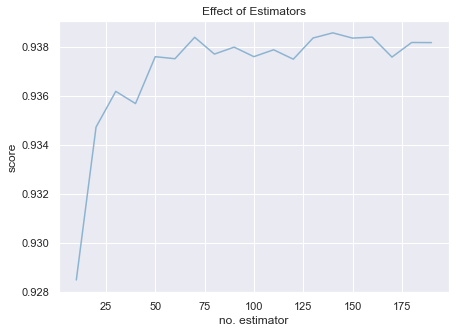

In [85]:
model = RandomForestRegressor(n_jobs=-1)
# Try different numbers of n_estimators - this takes a while to process
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, Y_train)
    scores.append(model.score(X_test, Y_test))
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("no. estimator")
plt.ylabel("score")
plt.plot(estimators, scores)
results = list(zip(estimators,scores))
results

In [86]:
predictions = model.predict(X_test)
'Mean Absolute Error:', metrics.mean_absolute_error(Y_test, predictions)

('Mean Absolute Error:', 0.24266750825403005)

In [87]:
'Mean Squared Error:', metrics.mean_squared_error(Y_test, predictions)

('Mean Squared Error:', 0.16135871727775447)

In [88]:
'Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, predictions))

('Root Mean Squared Error:', 0.40169480613738895)

##  Unregularized Linear Regression

By default, a linear regression model within SKLearn offers no penalites with handling the data. The linear regression model is quite simple to deploy to get an idea of how the model will perform. Additionally, there are some feature reduction techniques that can be used to train the model within the space to help with model optimization. 

Some disadvantages is that data has to be transformed to fit the linear straight-line relationships between so it assumes independance of the attributes. In conclusion, it is important for a researcher to understand why L1 Ridge and L2 Lasso penalities exist when comparing the Mean Absolute Error, Mean Squared Error, and Root Mean Errors to make sound judgement calls for their selecitons. 

For examples and overall discussion on Linear, Ridge, and Lasso Regression, please see the following resource: https://www.analyticsvidhya.com/blog/2017/06/a-comprehensive-guide-for-linear-ridge-and-lasso-regression/

In [40]:
X_train.shape 

(8130, 43)

In [41]:
X_test.shape

(2710, 43)

In [43]:
Y_train.shape

(8130,)

In [44]:
Y_test.shape


(2710,)

In [47]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data
from sklearn.linear_model import LinearRegression


In [89]:
#X = X_test.values.reshape(-1, 1)  # values converts it into a numpy array
X =X_train

In [90]:
#Y = Y_test.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Y= Y_train

In [91]:
linear_regressor = LinearRegression()  # create object for the class


In [92]:
linear_regressor.fit(X, Y)  # perform linear regression

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [93]:
Y_pred = linear_regressor.predict(X)  # make predictions

In [95]:
predictions = model.predict(X)
'Mean Absolute Error:', metrics.mean_absolute_error(Y, predictions)

('Mean Absolute Error:', 0.09467132776590952)

In [96]:
'Mean Squared Error:', metrics.mean_squared_error(Y, predictions)

('Mean Squared Error:', 0.02562936853689872)

In [97]:
'Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y, predictions))

('Root Mean Squared Error:', 0.16009175037115037)

## Regularization - Ridge Regression

We now enter the world of utilizing penalties with regression models to purposely control the outputs. Ridge will look to shrink the parameters of the features, thus to try to prevent multicollinearity. This will reduce model complexity as the coeffients are assumed to shrink.  Ridge can also use different alphas that will help with determining the model predictions from p=0.1 to p=10.0. 

In [100]:
## Regularization (Shrnkage penalty)
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

In [102]:
#Dtandardize Features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(X)

In [103]:
#Create ridge regression with an alpha value
regression =Ridge(alpha =0.5)

In [104]:
#Fit linear Regression
model = regression.fit(features_standardized, Y)

In [105]:
#Create ridge regression with three alpha values
regr_cv =RidgeCV(alphas= [0.1,1.0,10.0])

In [106]:
#Fit the Linear Regression 
model_cv = regr_cv.fit(features_standardized, Y)

In [107]:
# View coefficients
model_cv.coef_

array([ 0.01289768,  0.0270593 , -0.00249151, -0.00186889, -0.0484125 ,
       -0.01746795, -0.00146069, -0.0012518 ,  0.9971336 ,  0.00264378,
        0.13128789,  0.11699659,  0.09110529,  0.21500695,  0.29187797,
        0.10904114,  0.23425811,  0.18618875,  0.16635913,  0.1292673 ,
        0.12157072,  0.24526373,  0.13887258,  0.2381933 ,  0.10897263,
        0.14360645,  0.26645473,  0.46522392,  0.57910176,  0.30641129,
        0.20998731,  0.2110647 ,  0.22974336,  0.25950046,  0.18605393,
        0.34862351,  0.29415436,  0.25517853,  0.11591624,  0.10988196,
        0.15279957,  0.20788948,  0.13709871])

In [108]:
#View Alpha
model_cv.alpha_

0.1

In [109]:
## Example of code later. 
predictions = model.predict(X)
'Mean Absolute Error:', metrics.mean_absolute_error(Y, predictions)

('Mean Absolute Error:', 2.6465024395740218e+23)

In [110]:
'Mean Squared Error:', metrics.mean_squared_error(Y, predictions)

('Mean Squared Error:', 5.69423180725167e+50)

In [111]:
'Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y, predictions))

('Root Mean Squared Error:', 2.386258956452897e+25)

## Regularization - Lasso Regression

The important difference with Lasso is that there is feature extraction that naturally happens within the penalities. Therefore, a researcher might aim to utilize lasso if there ar a large number of features that are sought to be reduced within the modeling. Thus, lasso is most like a stepwise regression where the machine learns and determines which features should be dropped based off the statistical significance of all features loaded into the data frame. 

In [112]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

In [113]:
#StandarizeFeatures
Scaler = StandardScaler()
features_standarized = scaler.fit_transform(X)

In [114]:
#Create lasso regression with alpha value
regression = Lasso(alpha=0.5)

In [115]:
#Fit the linear regression 
model= regression.fit(features_standardized, Y)

In [116]:
#View coefficients
model.coef_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.01334437, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [118]:
#Create lasso regression with a high alpha
regression_a10 = Lasso(alpha=10)
model_a10 =regression_a10.fit(features_standardized, Y)
model_a10.coef_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [119]:
## Example of code later. 
predictions = model.predict(X)
'Mean Absolute Error:', metrics.mean_absolute_error(Y, predictions)

('Mean Absolute Error:', 1293244748.492794)

In [120]:
'Mean Squared Error:', metrics.mean_squared_error(Y, predictions)

('Mean Squared Error:', 1.9782963146000233e+18)

In [121]:
'Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y, predictions))

('Root Mean Squared Error:', 1406519219.420774)

## Discussion on Model Secleciton 

What is mean squared error? Mean Squared Error (MSE) tells the researcher how cloase a regression line is to a set of data within a distrubition. The construct takes the distance from the points in regression to find the errors or squared variance. 

Mean squared error (MSE) tells the researcher how close they are to finding the line best fit. The smaller the MSE the better the data fits the model. 

In the examples trained below, the model that best fits the experiement would be the unregularized linear model that has a score of 0.025. This model does not have penalities within the data frame and thus can have some assumptions and bias to how the data is handled. The random forest result of 0.16, which takes into account the classificaitons with some overfitting converns returns a score of 0.16 as the next best suitable model. Ridge Regression works to fit with alphas of p=0.01 to p=.10 giving larger errors in the data the highest at 5.69. The lasso regression scores at 1.9 as the model also offers feature extraction in the tuning process. 



**Random Forest Results:**
- ('Mean Absolute Error:', 0.24266750825403005)
- ('Mean Squared Error:', 0.16135871727775447)
- ('Root Mean Squared Error:', 0.40169480613738895)


**Unregularized Linear Regression Results:**
- ('Mean Absolute Error:', 0.09467132776590952)
- ('Mean Squared Error:', 0.02562936853689872)
- ('Root Mean Squared Error:', 0.16009175037115037)

**Ridge Regression L2 Results:**
- ('Mean Absolute Error:', 2.6465024395740218e+23)
- ('Mean Squared Error:', 5.69423180725167e+50)
- ('Root Mean Squared Error:', 2.386258956452897e+25)

**Lasso Regression L1 Results:**
- ('Mean Absolute Error:', 1293244748.492794)
- ('Mean Squared Error:', 1.9782963146000233e+18)
- ('Root Mean Squared Error:', 1406519219.420774)
